In [61]:
import numpy as np
import itertools
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from delegation_utils import retained, state, find_best_model, find_delegate_iteratively, get_human_errors, get_model_and_error, find_best_model_separable_alg

In [62]:
def generate_linear_coefficients(d):
    return np.random.default_rng().normal(0,1,d)

def get_separation_vector_from_linear(idxs, coefs):
    n_feats = len(idxs)
    return [np.dot(coefs[idxs], cat) for cat in itertools.product(range(2),repeat=n_feats)]

In [63]:
def get_f_sep(u,w,h,m):
    d = h+m
    f = np.zeros(shape=2*np.ones(d, np.int64))
    for i, hcat in enumerate(itertools.product(range(2),repeat=h)):
        for j, mcat in enumerate(itertools.product(range(2),repeat=m)):
            x_ij = state(hcat,mcat,np.arange(h),d)
            f[tuple(x_ij)] = u[i] + w[j]
    return f

In [64]:
def get_f_linear(v,d):
    f = np.zeros(2*np.ones(d, np.int64))

    for x in itertools.product(range(2),repeat=d):
        f[x] = np.dot(v,x)
        
    return f

In [65]:
def format_separable(h,m,d,f,Y):
    h_errors = get_human_errors(f, h, d)
    loss, model = get_model_and_error(m,h,d,f,np.arange(h,h+m),Y,h_errors)
    return model, loss, Y

def find_best_model_separable(h,m,d,u,w,f):
    Y = find_best_model_separable_alg(u,w,h)
    return format_separable(h,m,d,f,Y)

def find_best_model_separable_iter(h,m,d,f,quiet=True):
    best_model, best_loss, Y, _, _ = find_delegate_iteratively(h,m,0,d,f,quiet=quiet)
    return best_model, best_loss, Y

In [66]:
num_samples = 100

all_runs = []
for h in range(1,7):
    m = h
    d = m + h

    h_idxs = np.arange(h)
    m_idxs = np.arange(h,d)
    runs = []
    for i in tqdm(range(num_samples)):
        coefs = generate_linear_coefficients(d)

        u = get_separation_vector_from_linear(h_idxs, coefs)
        w = get_separation_vector_from_linear(m_idxs, coefs)

        f = get_f_sep(u,w,h,m)

        model, loss, Y = find_best_model_separable(h,m,d,u,w,f)
        model_iter, loss_iter, Y_iter = find_best_model_separable_iter(h,m,d,f)

        run = {
            'coefs': coefs,
            'model': model, 'model_iter': model_iter,
            'loss': loss, 'loss_iter': loss_iter,
            'Y': Y, 'Y_iter': Y_iter
        }
        runs.append(run)
    all_runs.append(runs)

100%|█████████████████████████████████████████████████████████████| 100/100 [03:54<00:00,  2.35s/it]


In [67]:
def process_run_entries(all_runs, fn, num_samples):
    entries = []
    for h in range(1,7):
        m = h
        d = m + h
        runs = all_runs[h-1]
        for i in tqdm(range(num_samples)):
            entries.extend(fn(h,m,d,runs[i]))
    return entries

In [79]:
def get_ratios(h,m,d,run):
    coefs = run['coefs']
    f = get_f_linear(coefs,d)
    m_idxs = np.arange(h,d)
    
    h_errors = get_human_errors(f, h, d)
    loss_obliv, _ = get_model_and_error(m,h,d,f,m_idxs,[],h_errors)

    loss = run['loss']
    loss_iter = run['loss_iter']

    iter_ratio = (loss_iter - loss) / loss
    entry_iter = { 'h':h, 'Loss ratio': iter_ratio, 'Type': 'Iterative' }
    
    obliv_ratio = (loss_obliv - loss) / loss
    entry_obliv = { 'h': h, 'Loss ratio': obliv_ratio, 'Type': 'Oblivious' }
    
    return [entry_obliv, entry_iter]

In [80]:
ratios = process_run_entries(all_runs, get_ratios, num_samples)

100%|█████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]


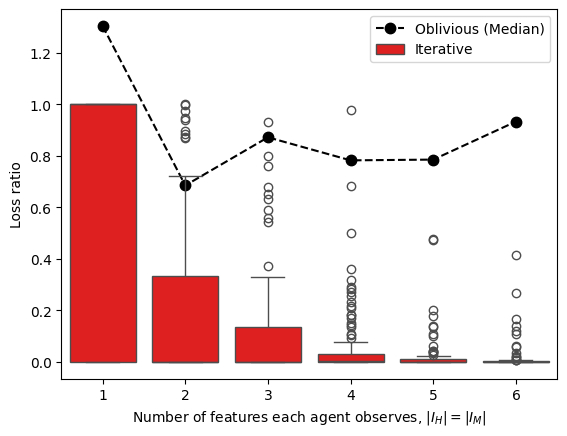

In [132]:
df = pd.DataFrame(all_ratios)

df_iter = df[df['Type'] == 'Iterative']
df_obliv = df[df['Type'] == 'Oblivious']

medians = []
for h in range(1,7):
    df_h = df_obliv[df_obliv['h'] == h]
    medians.append(np.median(df_h['Loss ratio']))
plt.plot(np.arange(6), medians, color='black', linestyle='--', marker='.', markersize=15)

sns.boxplot(df_iter, x='h', y='Loss ratio', color='red')
plt.legend(['Oblivious (Median)', 'Iterative'])
plt.xlabel(r'Number of features each agent observes, $|I_H| = |I_M|$')
plt.savefig('loss_ratios.png')
plt.show()

### Computing the proportion of times the iterative process finds the optimal solution

In [ ]:
num_samples = 1000

entries = []
for h in range(1,7):
    for m in range(1,7):
        d = h + m
        for i in range(num_samples):
            coefs = generate_linear_coefficients(d)

            h_idxs = np.arange(h)
            m_idxs = np.arange(h,d)
            u = get_separation_vector_from_linear(h_idxs, coefs)
            w = get_separation_vector_from_linear(m_idxs, coefs)
    
            f = get_f_sep(u,w,h,m)
    
            model, loss, Y = find_best_model_separable(h,m,d,u,w,f)
            model_iter, loss_iter, Y_iter = find_best_model_separable_iter(h,m,d,f)
            
            run = {
                'h': h,
                'm': m,
                'coefs': coefs,
                'model': model, 'model_iter': model_iter,
                'loss': loss, 'loss_iter': loss_iter,
                'Y': Y, 'Y_iter': Y_iter
            }
            entries.append(run)

In [ ]:
df = pd.DataFrame(entries)

props = np.zeros((6,6))
for h in range(1,7):
    df_h = df[df['h'] == h]
    for m in range(1,7):
        df_hm = df_h[df_h['m'] == m]
        count = 0
        for index, row in df_hm.iterrows():
            count += (row['Y'] == row['Y_iter'])
        props[h-1,m-1] = count / num_samples

for h in range(1,7):
    print(props[h-1])